<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-data" data-toc-modified-id="Import-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Do-later" data-toc-modified-id="Do-later-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Do later</a></span></li></ul></li><li><span><a href="#Model-architecture¶" data-toc-modified-id="Model-architecture¶-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model architecture¶</a></span></li></ul></div>

# Import data

In [112]:
# credit: https://github.com/amirrezaeian/Individual-household-electric-power-consumption-Data-Set-/blob/master/data_e_power.ipynb

In [86]:
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

In [87]:
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [88]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [89]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [90]:
df_org=pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])
df_org.columns

Index(['dt', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [91]:
# load the dataset
## Data can be downloaded from: http://archive.ics.uci.edu/ml/machine-learning-databases/00235/
## Just open the zip file and grab the file 'household_power_consumption.txt' put it in the directory 
## that you would like to run the code. 

df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [92]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [93]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [94]:
df.shape

(2075259, 7)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [96]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [97]:
# filling nan with mean in any columns

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [98]:
# check to make sure that there are not any more nan
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# EDA

## Do later

In [99]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [100]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [101]:
#scale all features in range of [0,1]
values = df_resample.values 

## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [102]:
reframed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723


In [103]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)


In [104]:
reframed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555


In [105]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


# Model architecture¶

In [106]:
#1) LSTM with 100 neurons in the first visible layer
#3) dropout 20%
#4) 1 neuron in the output layer for predicting Global_active_power.
#5) The input shape will be 1 time step with 7 features.
#6) Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
#7) The model will be fit for 20 training epochs with a batch size of 70.

In [107]:
train_X.shape

((8760, 1, 7),)

In [108]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



In [109]:
test_X.shape[0]

25828

Train on 8760 samples, validate on 25828 samples
Epoch 1/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 2/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 3/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 4/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 5/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 6/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 7/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 8/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 9/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 10/100
 - 1s - loss: 0.0101 - val_loss: 0.0086
Epoch 11/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 12/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 13/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 14/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 15/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 16/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 17/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 18/100
 - 1s - loss: 0.0101 - val_loss: 0.0087
Epoch 

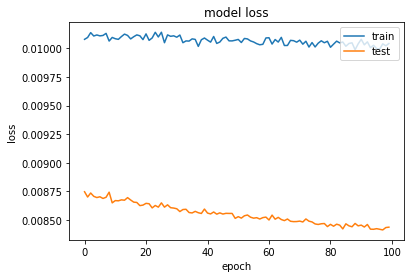

training took 59.532201 seconds


In [111]:
from timeit import default_timer as timer
# fit network
start =timer()

history = model.fit(train_X, train_y, epochs=100, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

training_time = timer()-start
print("training took %f seconds" % training_time)


In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))

In [66]:
yhat.shape, test_X.shape

((25828, 1), (25828, 7))

In [65]:
test_X[:, -6:]

array([[0.08458889, 0.47831591, 0.35341942, 0.        , 0.00897344,
        0.80897138],
       [0.05484288, 0.45310572, 0.37625538, 0.        , 0.        ,
        0.80433101],
       [0.27804563, 0.47152585, 0.41056911, 0.        , 0.0086145 ,
        0.80742459],
       ...,
       [0.06934998, 0.44873246, 0.21939264, 0.        , 0.        ,
        0.        ],
       [0.07752906, 0.41839455, 0.235055  , 0.        , 0.00143575,
        0.        ],
       [0.07899268, 0.52024552, 0.15817791, 0.        , 0.022972  ,
        0.        ]])

In [67]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.617


In [85]:
inv_y.max(), inv_y.mean()

(6.560533333333333, 1.0803389754527748)

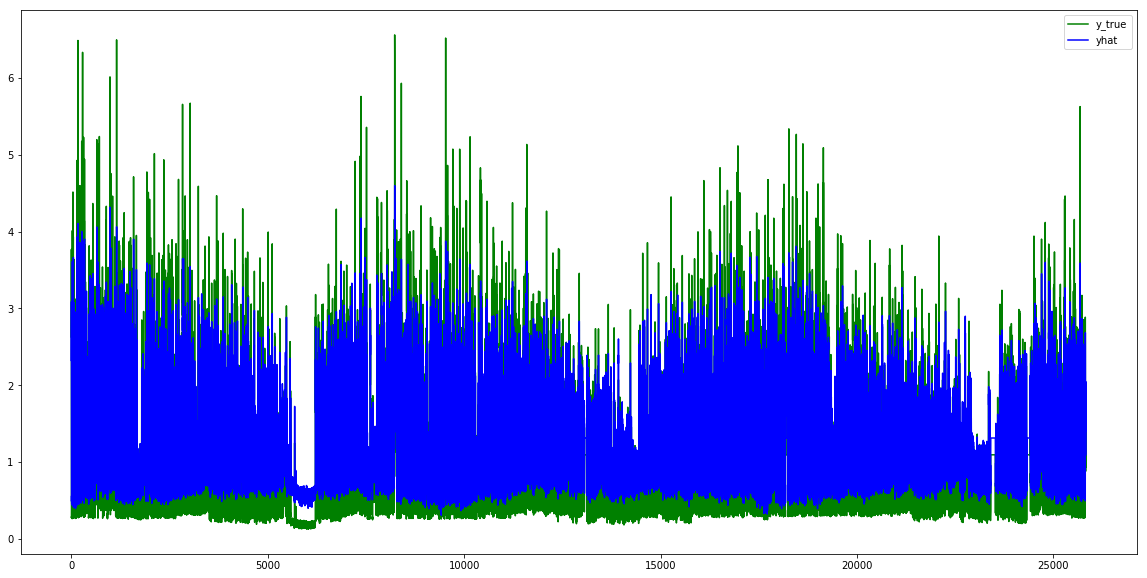

In [84]:
import pylab 
plt.figure(figsize=(20,10))

pylab.plot(inv_y, '-g', label='y_true')
pylab.plot(inv_yhat, '-b', label='yhat')
pylab.legend(loc='upper right')

pylab.show()